In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import random
from copy import deepcopy
import math
from matplotlib import pyplot as plt
import datetime as dt
import copy
import requests
import json
import geopy.distance

In [ ]:

customers_data = pd.read_excel('/content/2_detail_table_customers.xls')
vehicles_data = pd.read_excel('/content/3_detail_table_vehicles.xls')
depots_data = pd.read_excel('/content/4_detail_table_depots.xls')
cust_depot_dist_data = pd.read_excel('/content/6_detail_table_cust_depots_distances.xls')

In [ ]:

route_id_list = [2946091, 2922001, 2939484, 2958047, 2970877, 2990001, 3005971, 2604001, 3016355, 3027038, 3044702]
route_id = 2946091

customers = customers_data[customers_data["ROUTE_ID"]==route_id]
vehicles = vehicles_data[vehicles_data["ROUTE_ID"]==route_id]
depots = depots_data[depots_data["ROUTE_ID"]==route_id]
cust_depot_dist = cust_depot_dist_data[cust_depot_dist_data["ROUTE_ID"]==route_id]


In [ ]:

positions_customers = {}
for i in customers.index:
    positions_customers[i+1] = (customers.loc[i, 'CUSTOMER_LATITUDE'], customers.loc[i, 'CUSTOMER_LONGITUDE'])


positions_customers[0] = (depots.loc[0, 'DEPOT_LATITUDE'], depots.loc[0, 'DEPOT_LONGITUDE'])


articles_customers = {}
for i in customers.index:
    articles_customers[i+1] = (customers.loc[i, 'TOTAL_VOLUME_M3'], customers.loc[i, 'TOTAL_WEIGHT_KG'])


for i in vehicles.index:
    constraints_vehicles[i+1] = (vehicles.loc[i, 'VEHICLE_TOTAL_VOLUME_M3'], vehicles.loc[i, 'VEHICLE_TOTAL_WEIGHT_KG'], vehicles.loc[i, 'VEHICLE_VARIABLE_COST_KM'])


In [ ]:


def position_client(num_client):
    """

    """
    return positions_customers[num_client]


def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    r = 6371  # rayon terre
    return c * r

def calculate_distance(client1, client2):
    """

    """
    lat_client_1, lon_client_1 = position_client(client1)
    lat_client_2, lon_client_2 = position_client(client2)
    return haversine(lat_client_1, lon_client_1, lat_client_2, lon_client_2)


In [ ]:


def generate_random_schedule(nb_customers, nb_vehicles_max):
    """
    Génère un ordonnancement aléatoire des customers avec un nombre maximal de véhicules.
    """
    ordonnancement = [[] for _ in range(nb_vehicles_max)]
    liste_customers = list(range(1, nb_customers + 1))
    random.shuffle(liste_customers)
    for client in liste_customers:
        vehicule_choisi = random.randint(0, nb_vehicles_max - 1)
        ordonnancement[vehicule_choisi].append(client)
    return ordonnancement

def generate_valid_random_schedule(nb_customers, nb_vehicles_max):
    s = generate_random_schedule(nb_customers,nb_vehicles_max)
    while not is_schedule_valid(s):
          s = generate_random_schedule(nb_customers, nb_vehicles_max)
    return s


def count_lists(liste_principale):

    compteur_listes = 0


    for element in liste_principale:

        if isinstance(element, list):

            compteur_listes += 1

    return compteur_listes


def is_schedule_valid(ordonnancement):
    res = True
    for r in range(count_lists(ordonnancement)):
        vehicule_volume, vehicle_weight = 0, 0
        for c in ordonnancement[r]:
            if c==0:
              vehicule_volume=0
              vehicle_weight=0
            else :
              vehicule_volume += articles_customers[c][0]
              vehicle_weight += articles_customers[c][1]
        res = res and vehicule_volume <= constraints_vehicles[r+1][0] and vehicle_weight <= constraints_vehicles[r+1][1]
    return res

def is_schedule_valid_relaxed(ordonnancement):
    res = True
    for r in range(count_lists(ordonnancement)):
        vehicule_volume, vehicle_weight = 0, 0
        for c in ordonnancement[r]:
            if c==0:
              vehicule_volume=0
              vehicle_weight=0
            else :
              vehicule_volume += articles_customers[c][0]
              vehicle_weight += articles_customers[c][1]
        res = res and vehicule_volume <= 300000 and vehicle_weight <= 30000
    return res




In [ ]:

def get_random_neighbor(ordonnancement):
    ordonnancement_modifie = deepcopy(ordonnancement)
    indice_route = random.randint(0, len(ordonnancement_modifie) - 1)
    while not ordonnancement_modifie[indice_route]:
        indice_route = random.randint(0, len(ordonnancement_modifie) - 1)
    indice_client = random.randint(0, len(ordonnancement_modifie[indice_route]) - 1)
    client = ordonnancement_modifie[indice_route].pop(indice_client)
    nouvelle_route = random.randint(0, len(ordonnancement_modifie) - 1)
    ordonnancement_modifie[nouvelle_route].append(client)
    return ordonnancement_modifie


def swap_customers(ordonnancement):
    ordonnancement_modifie = deepcopy(ordonnancement)
    if len(ordonnancement_modifie) < 2:
        return ordonnancement
    route_a, route_b = random.sample(range(len(ordonnancement_modifie)), 2)
    if ordonnancement_modifie[route_a] and ordonnancement_modifie[route_b]:
        client_a = random.choice(ordonnancement_modifie[route_a])
        client_b = random.choice(ordonnancement_modifie[route_b])
        ordonnancement_modifie[route_a].append(client_b)
        ordonnancement_modifie[route_b].append(client_a)
        ordonnancement_modifie[route_a].remove(client_a)
        ordonnancement_modifie[route_b].remove(client_b)
    return ordonnancement_modifie


def merge_split_routes(ordonnancement):
    ordonnancement_modifie = deepcopy(ordonnancement)
    n_routes = len(ordonnancement_modifie)
    if n_routes < 2:
        return ordonnancement_modifie
    route_a, route_b = random.sample(range(n_routes), 2)
    route_combinee = ordonnancement_modifie[route_a] + ordonnancement_modifie[route_b]

    if not route_combinee:
        return ordonnancement_modifie

    point_division = random.randint(1, len(route_combinee)-1)

    nouvelle_route_a = route_combinee[:point_division]
    nouvelle_route_b = route_combinee[point_division:]

    ordonnancement_modifie[route_a] = nouvelle_route_a
    ordonnancement_modifie[route_b] = nouvelle_route_b

    return ordonnancement_modifie



def shift_customer_in_route(ordonnancement):
    ordonnancement_modifie = deepcopy(ordonnancement)
    indice_route = random.randint(0, len(ordonnancement_modifie) - 1)
    if len(ordonnancement_modifie[indice_route]) > 1:
        client_index, nouvelle_position = random.sample(range(len(ordonnancement_modifie[indice_route])), 2)
        client = ordonnancement_modifie[indice_route].pop(client_index)
        ordonnancement_modifie[indice_route].insert(nouvelle_position, client)
    return ordonnancement_modifie



In [ ]:

def get_random_neighbor_valid(ordonnancement):
    ordonnancement_modifie = deepcopy(ordonnancement)
    tentatives = 0
    max_tentatives = 1000

    while tentatives < max_tentatives:
        tentatives += 1
        indice_route = random.randint(0, len(ordonnancement_modifie) - 1)
        while not ordonnancement_modifie[indice_route]:
            indice_route = random.randint(0, len(ordonnancement_modifie) - 1)
        indice_client = random.randint(0, len(ordonnancement_modifie[indice_route]) - 1)
        client = ordonnancement_modifie[indice_route].pop(indice_client)
        nouvelle_route = random.randint(0, len(ordonnancement_modifie) - 1)
        ordonnancement_modifie[nouvelle_route].append(client)

        if is_schedule_valid_relaxed(ordonnancement_modifie):
            return ordonnancement_modifie

        ordonnancement_modifie[nouvelle_route].remove(client)
        ordonnancement_modifie[indice_route].append(client)

    return ordonnancement


def swap_customers_valide(ordonnancement):
    ordonnancement_modifie = deepcopy(ordonnancement)
    tentatives = 0
    max_tentatives = 1000

    while tentatives < max_tentatives:
        tentatives += 1
        if len(ordonnancement_modifie) < 2:
            return ordonnancement

        route_a, route_b = random.sample(range(len(ordonnancement_modifie)), 2)
        if ordonnancement_modifie[route_a] and ordonnancement_modifie[route_b]:
            client_a = random.choice(ordonnancement_modifie[route_a])
            client_b = random.choice(ordonnancement_modifie[route_b])

            ordonnancement_modifie[route_a].append(client_b)
            ordonnancement_modifie[route_b].append(client_a)
            ordonnancement_modifie[route_a].remove(client_a)
            ordonnancement_modifie[route_b].remove(client_b)

            if is_schedule_valid_relaxed(ordonnancement_modifie):
                return ordonnancement_modifie
            else:

                ordonnancement_modifie[route_a].append(client_a)
                ordonnancement_modifie[route_b].append(client_b)
                ordonnancement_modifie[route_a].remove(client_b)
                ordonnancement_modifie[route_b].remove(client_a)

    return ordonnancement


def merge_split_routes_valid(ordonnancement):
    ordonnancement_modifie = deepcopy(ordonnancement)
    tentatives = 0
    max_tentatives = 1000

    while tentatives < max_tentatives:
        tentatives += 1
        n_routes = len(ordonnancement_modifie)
        if n_routes < 2:
            return ordonnancement_modifie

        route_a, route_b = random.sample(range(n_routes), 2)
        route_combinee = ordonnancement_modifie[route_a] + ordonnancement_modifie[route_b]

        if not route_combinee:
            continue

        point_division = random.randint(1, len(route_combinee)-1)
        nouvelle_route_a = route_combinee[:point_division]
        nouvelle_route_b = route_combinee[point_division:]


        ordonnancement_modifie[route_a] = nouvelle_route_a
        ordonnancement_modifie[route_b] = nouvelle_route_b

        if is_schedule_valid_relaxed(ordonnancement_modifie):
            return ordonnancement_modifie

        else:

            ordonnancement_modifie[route_a] = ordonnancement[route_a]
            ordonnancement_modifie[route_b] = ordonnancement[route_b]

    return ordonnancement

def shift_customer_in_route_valid(ordonnancement):
    ordonnancement_modifie = deepcopy(ordonnancement)
    tentatives = 0
    max_tentatives = 1000

    while tentatives < max_tentatives:
        tentatives += 1
        indice_route = random.randint(0, len(ordonnancement_modifie) - 1)
        if len(ordonnancement_modifie[indice_route]) > 1:
            client_index, nouvelle_position = random.sample(range(len(ordonnancement_modifie[indice_route])), 2)
            client = ordonnancement_modifie[indice_route].pop(client_index)
            ordonnancement_modifie[indice_route].insert(nouvelle_position, client)

            if is_schedule_valid_relaxed(ordonnancement_modifie):
                return ordonnancement_modifie

            else:

                ordonnancement_modifie = deepcopy(ordonnancement)

    return ordonnancement



In [ ]:

def calculate_cost(ordonnancement):
    """
    Calcule le coût associé à un ordonnancement donné, prenant en compte la distance
    """
    cout_total = 0
    Nbr_camions = 0
    for route in ordonnancement:
        distance_totale = 0
        dernier_client = 0
        for client in route:
            distance_totale += calculate_distance(dernier_client, client)
            dernier_client = client
        if distance_totale > 0:
            Nbr_camions += 1
        distance_totale += calculate_distance(dernier_client, 0)
        cout_total += distance_totale
    return cout_total * (1 + Nbr_camions/20)





def optimiser_ordonnancement(temperature_initiale, iterations_par_cycle, facteur_refroidissement, calculer_cout, etat_initial):
    """

    """
    if etat_initial is None:
        etat_courant = generate_random_schedule(len(customers), len(vehicles))
    else:
        etat_courant = etat_initial

    meilleur_etat = deepcopy(etat_courant)
    meilleur_cout = calculer_cout(meilleur_etat)
    couts_evolution = [meilleur_cout]
    temperature = temperature_initiale

    while temperature > 1:
        for _ in range(iterations_par_cycle):
            voisin = strategie_voisin(etat_courant)
            cout_voisin = calculer_cout(voisin)
            delta_cout = cout_voisin - calculer_cout(etat_courant)

            if delta_cout < 0 or random.random() < math.exp(-delta_cout / temperature):
                etat_courant = voisin

                if cout_voisin < meilleur_cout:
                    meilleur_etat = deepcopy(voisin)
                    meilleur_cout = cout_voisin

        couts_evolution.append(meilleur_cout)
        temperature *= facteur_refroidissement

    return meilleur_cout, meilleur_etat, couts_evolution


In [ ]:

def visualise_strategies(strategies,temperature_initiale,iterations_par_cycle,facteur_refroidissement,etat_initial):
    plt.figure(figsize=(12, 8))

    for strategie in strategies:
        _, _, couts_evolution = optimiser_ordonnancement(
            temperature_initiale,
            iterations_par_cycle,
            facteur_refroidissement,
            calculate_cost,
            etat_initial,
            strategie_voisin=strategie["fonction"]
        )
        plt.plot(couts_evolution, label=strategie["label"])

    plt.title("Comparaison des Stratégies de Voisinage")
    plt.xlabel("Cycle de Température")
    plt.ylabel("Meilleur Coût")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:

strategie = [
    {"fonction": merge_split_routes_valid, "label": "Fusionner et Diviser"}
]

strategies = [
    {"fonction": get_random_neighbor_valid, "label": "Déplacement Aléatoire"},
    {"fonction": swap_customers_valide, "label": "Échange de customers"},
    {"fonction": merge_split_routes_valid, "label": "Fusionner et Diviser"},
    {"fonction": shift_customer_in_route_valid, "label": "Déplacement dans Route"}
]



In [ ]:
import datetime as dt
import copy

import requests
import json
import geopy.distance

In [ ]:
def route(coord1, coord2):
  # coord1 = lat1, long1; coord2 = lat2, long2
  r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{coord1[1]},{coord1[0]};{coord2[1]},{coord2[0]}?overview=false""")
  route_1 = json.loads(r.content)["routes"][0]
  return route_1["distance"], route_1["duration"]

def toDatetime(t_sec):
  return str(dt.timedelta(seconds=t_sec))

In [ ]:
RezCoord = [50.610424706556, 3.1482419048540216]
CentraleCoord = [50.60693833214689, 3.1365456828632503]

print(route(RezCoord, CentraleCoord))
print(toDatetime(route(RezCoord, CentraleCoord)[1]))

(1434.3, 227.1)
0:03:47.100000


In [ ]:


def algoListeSimple(Nbcustomers, NbVoitures, depot, df):
  dist_parcourue=[]
  ordonnancement=[]
  df=df.head(Nbcustomers)



  position_voitures=[]
  for i in range(0, NbVoitures):
    position_voitures.append(depot)

  data=df.to_dict(orient='index')
  customers=list(data)


  for i in range(0, NbVoitures):
    dist_parcourue.append(0)
    ordonnancement.append([0])

  while len(customers)!=0:

    d = min(dist_parcourue)
    voitureDispo = dist_parcourue.index(d)
    last_loc = position_voitures[voitureDispo]


    clientNb = client_prio(data, last_loc, customers)


    clientCoord = [data[clientNb]["CUSTOMER_LATITUDE"], data[clientNb]["CUSTOMER_LONGITUDE"]]
    distance = haversine(last_loc[0], last_loc[1], clientCoord[0], clientCoord[1])
    dist_parcourue[voitureDispo]+=distance


    ordonnancement[voitureDispo].append(data[clientNb]["CUSTOMER_NUMBER"])
    customers.remove(clientNb)
    position_voitures[voitureDispo] = clientCoord


  for i in range(0, NbVoitures):
    ordonnancement[i].append(0)

  return ordonnancement

def client_prio(data, last_loc, customers):

  closestClient=customers[0]
  client0coord = [data[closestClient]["CUSTOMER_LATITUDE"], data[closestClient]["CUSTOMER_LONGITUDE"] ]
  distMin=haversine(last_loc[0], last_loc[1], client0coord[0], client0coord[1])
  for i in customers[1:]:
    clientCoord = [ data[i]["CUSTOMER_LATITUDE"], data[i]["CUSTOMER_LONGITUDE"] ]
    distance = haversine(last_loc[0], last_loc[1], clientCoord[0], clientCoord[1])
    if distance<distMin:
      distMin = distance
      closestClient = i
  return closestClient

In [ ]:
def ordo_to_dataset(ordo, data, depot):

  df=[]
  for i in range(len(ordo)):
    d=0
    last_loc=depot
    for client in ordo[i]:
      if client==0:
        clientCoord = depot
      else:
        clientCoord = [data.loc[data['CUSTOMER_NUMBER']==client, 'CUSTOMER_LATITUDE'].iloc[0], data.loc[data['CUSTOMER_NUMBER']==client, 'CUSTOMER_LONGITUDE'].iloc[0]]
      r1 = haversine(last_loc[0], last_loc[1], clientCoord[0], clientCoord[1])
      d_livraison = d + r1
      distance_parcourue = r1
      df.append({
            'Type': client,
            'Start': d,
            'End': d_livraison,
            'Task': i,
            'CUSTOMER_LATITUDE':clientCoord[0],
            'CUSTOMER_LONGITUDE':clientCoord[1],
            'Distance': r1
            })
      last_loc=clientCoord
      d=d_livraison
  return pd.DataFrame(df)

In [ ]:
def showRoute(ordo, df, depot):

  ordo_df=ordo_to_dataset(ordo, df, depot)
  fig, ax = plt.subplots()

  for i in range(0,8):
    ordo_p=ordo_df[ordo_df['Task']==i]
    ax.plot(ordo_p["CUSTOMER_LONGITUDE"], ordo_p["CUSTOMER_LATITUDE"], label=f"Type {i}")

In [ ]:
def diagrammeDeGantt(df0):


    df=df0.copy()
    colors_choice=['blue', 'orange', 'green','red','purple','brown','pink','gray','olive','cyan']
    type_list = df['Type'].unique()
    colors = {}
    bar_types_list=[]
    colors_already_in_legend=[]
    for i in range(len(type_list)):
        colors[type_list[i]] = colors_choice[i%len(colors_choice)]
    machines=[0,1,2,3]

    df.Start=pd.to_datetime(df.Start, unit='h')
    df.End=pd.to_datetime(df.End, unit='h')

    df['Duration']=df.End-df.Start
    df.Duration=df.Duration.apply(lambda x: x.days+1)

    df=df.sort_values(by='Start', ascending=True)

    p_start=df.Start.min()
    p_end=df.End.max()
    p_duration=(p_end-p_start).days+1

    df['rel_start']=df.Start.apply(lambda x: (x-p_start).days)

    x_ticks=[i for i in range(p_duration+1)]
    yticks=[1,2,3]
    x_labels=[(p_start+ dt.timedelta(days=i)).strftime('%d-%b')
            for i in x_ticks]

    plt.figure(figsize=(8,4))
    plt.title('Diagramme de Gantt', size=18)
    for i in range(df.shape[0]):
        color=colors[df.Type[i]]
        tk=machines[df.Task[i]]
        a=plt.barh(y=tk, left=df.rel_start[i], width=df.Duration[i], alpha=0.5, color=color)
        if 'Description' in df.columns:
            plt.text(x=df.rel_start[i]+df.Duration[i], y=df.Task[i], s=df.Description[i])
        if(not(color in colors_already_in_legend)):
            colors_already_in_legend.append(color)
            bar_types_list.append(a)


    plt.gca().invert_yaxis()
    plt.yticks(ticks=yticks, labels=[1,2,3])
    plt.grid(axis='x')

    plt.legend(bar_types_list, type_list, fontsize='medium', title='Type', title_fontsize='large')

    plt.show()

In [ ]:
def showEachRoute(ordo):
  ordo_df=ordo_to_dataset(ordo, data_test, depot)
  for i in range(8):
    ordo_voiture_i=ordo_df[ordo_df['Task']==i]
    latitude = ordo_voiture_i['CUSTOMER_LATITUDE'].tolist()
    longitude = ordo_voiture_i['CUSTOMER_LONGITUDE'].tolist()
    customer_codes = ordo_voiture_i['Type'].tolist()


    plt.figure(figsize=(10, 6))


    for i in range(len(latitude)):
      top_or_bot = (-1)**i
      plt.annotate(customer_codes[i], (longitude[i], latitude[i]), textcoords="offset points", xytext=(0,top_or_bot*10), ha='center', fontsize=6)


    plt.scatter(longitude, latitude, color='blue')
    for i in range(len(latitude)-1):
      plt.plot([longitude[i], longitude[i+1]], [latitude[i], latitude[i+1]], color='red')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Customer Locations')
    plt.grid(True)
    plt.show()

In [ ]:
def ordo_to_tab_list(ordo):

  tab_list=[]
  for voiture in ordo:
    for code in voiture:
      tab_list.append(code)
    tab_list.append(-1)
  tab_list.pop()
  return tab_list

def tab_list_to_ordo(tab_list):

  ordo=[[]]
  for i in tab_list:
    if i==-1:
      ordo.append([])
    else:
      ordo[-1].append(i)
  return ordo

In [ ]:
def algoTabou(s_depart, NbIterMax, Nbvoisins, Historique_scores):
  s_avec_0 = ordo_to_tab_list(s_depart)
  s = [x for x in s_avec_0 if x != 0]
  s_star=s
  nb_iter=0
  T=[]
  meil_score = calculate_cost(tab_list_to_ordo(s_star))
  while (nb_iter<NbIterMax):
    print("Step " + str(nb_iter))
    nb_iter+=1

    V=voisins(s, Nbvoisins)
    v,M=choixVoisin(V,T)
    if(M<meil_score):

      s_star=v
      meil_score=M
      s=v
      print("Amélioration : " +str(meil_score))
    else:

      T.append(v)


      s=v
    Historique_scores.append(meil_score)
  return tab_list_to_ordo(s_star)

def voisins(sol, NbVoisins):

  V=[]

  for i in range(NbVoisins):
    a,b=random.randint(0,len(sol)-1), random.randint(0,len(sol)-1)
    v=copy.deepcopy(sol)
    v[a],v[b]=v[b],v[a]

    if(is_schedule_valid(tab_list_to_ordo(v))):
      V.append(v)


  for i in range(NbVoisins):
    a,b=random.randint(0,len(sol)-1), random.randint(0,len(sol)-1)
    v=copy.deepcopy(sol)
    v[a:b]= reversed(v[a:b])

    if(is_schedule_valid(tab_list_to_ordo(v))):
      V.append(v)

  if(len(V)==0):
    print("Pas de solutions voisines trouvées")
  return V


def choixVoisin(V,T):

  init=0
  while (V[init] in T):
    init+=1
  MeilleurVoisin=init
  MeilleurScore=calculate_cost(tab_list_to_ordo(V[init]))

  for k in range(0,len(V)):
    Score=calculate_cost(tab_list_to_ordo(V[k]))
    if (Score<MeilleurScore and not(V[k] in T)):
      MeilleurVoisin=k
      MeilleurScore=Score
  return V[MeilleurVoisin], MeilleurScore


In [ ]:
def choose_S(P, energy):
    """

    """
    P_b = deepcopy(P)
    P_b.sort(key=energy)
    P_b = P_b[0:len(P_b)//2]*2
    random.shuffle(P_b)
    return P_b

In [ ]:
def croisement(p1, p2, n):
    """

    """
    p1_tot = []
    p2_tot = []

    i = n+1
    for r in p1:
        p1_tot += r + [i]
        i+=1
    p1_tot.pop()

    i = n+1
    for r in p2:
        p2_tot += r + [i]
        i+=1
    p2_tot.pop()

    d = random.randint(0, len(p1_tot)-2)
    f = random.randint(d+1, len(p1_tot)-1)
    p1_sub = p1_tot[d:f]
    p2_sub = p2_tot[d:f]

    p2_tot_b = deepcopy(p2_tot)
    p1_tot_b = deepcopy(p1_tot)

    for e in range(len(p1_sub)):
        if (not p1_sub[e] in p2_sub ) and (not p2_sub[e] in p1_sub):
            i_e = p2_tot.index(p1_sub[e])
            p2_tot_b[i_e] = p2_sub[e]
    for e in range(len(p2_sub)):
        if (not p2_sub[e] in p1_sub) and (not p1_sub[e] in p2_sub):
            i_e = p1_tot.index(p2_sub[e])
            p1_tot_b[i_e] = p1_sub[e]

    for j in range(d,f):
        if (not p1_sub[j-d] in p2_sub ) and (not p2_sub[j-d] in p1_sub):
            p2_tot_b[j] = p1_sub[j-d]
            p1_tot_b[j] = p2_sub[j-d]

    #print(p1_tot_b, p2_tot_b, p1_sub, p2_sub)

    i_1 = [-1]
    i_2 = [-1]
    for k in range(n+1, i-1):
        k_1 = p1_tot_b.index(k)
        i_1.append(k_1)
        k_2 = p2_tot_b.index(k)
        i_2.append(k_2)
    i_1.sort()
    i_2.sort()
    #print(i_1, i_2)

    p1_res = []
    p2_res = []
    for k_b in range(len(i_1)-1):
        #print(p1_tot_b[i_1[k_b]+1:i_1[k_b+1]])
        p1_res.append(p1_tot_b[i_1[k_b]+1:i_1[k_b+1]])
        p2_res.append(p2_tot_b[i_2[k_b]+1:i_2[k_b+1]])
    #print(p1_tot_b[i_1[k_b+1]+1:])
    p1_res.append(p1_tot_b[i_1[k_b+1]+1:])
    p2_res.append(p2_tot_b[i_2[k_b+1]+1:])

    return(p1_res, p2_res)

In [ ]:
def mutation(p, n):
    p_tot = []

    i = n+1
    for r in p:
        p_tot += r + [i]
        i+=1
    p_tot.pop()

    d = random.randint(0, len(p_tot)-2)
    f = random.randint(d+1, len(p_tot)-1)

    for k in range((f-d)//2):
        p_tot[d+k], p_tot[f-k] = p_tot[f-k], p_tot[d+k]

    i_1 = [-1]
    for k in range(n+1, i-1):
        k_1 = p_tot.index(k)
        i_1.append(k_1)

    i_1.sort()
    p_res = []
    for k_b in range(len(i_1)-1):
        #print(p1_tot_b[i_1[k_b]+1:i_1[k_b+1]])
        p_res.append(p_tot[i_1[k_b]+1:i_1[k_b+1]])
    #print(p1_tot_b[i_1[k_b+1]+1:])
    p_res.append(p_tot[i_1[k_b+1]+1:])

    return(p_res)

In [ ]:
def algoGenetique(nb_gen = 100, nb_iter = 500, f_cout=calculate_cost, P_cross = 0.7, P_mut = 0.1):

    N = nb_gen//2*2
    P = [] #N individus

    nb_client = len(customers)

    for _ in range(N):
        s = generate_random_schedule(nb_client, len(vehicles))
        while not is_schedule_valid(s):
            s = generate_random_schedule(nb_client, len(vehicles))
        P.append(s)

    St_1 = deepcopy(P)

    for _ in range(nb_iter):
        St = choose_S(St_1, f_cout)
        St_1 = []
        for i in range(N//2):
            if random.random()<P_cross:
                A, B = croisement(St[i*2], St[i*2+1], nb_client)
                #print(A,B)
                #print(is_order_valid(A))
                #print(is_order_valid(B))
                while not is_schedule_valid(A) or not is_schedule_valid(B):
                    A, B = croisement(St[i*2], St[i*2+1], nb_client)
                St_1.append(A)
                St_1.append(B)
            else:
                St_1.append(deepcopy(St[i*2]))
                St_1.append(deepcopy(St[i*2+1]))

        for i in range(N):
            if random.random()<P_mut:
                m_i = mutation(St_1[i], nb_client)
                while not is_schedule_valid(m_i):
                    m_i = mutation(St_1[i], nb_client)
                St_1[i] = m_i
    print(St_1[0])
    historique = []
    m = 0
    m_e = f_cout(St_1[0])
    for k in range(1,nb_gen):
        e = f_cout(St_1[k])
        historique.append(e)
        if e<m_e:
            m=k
            m_e=e
    plt.plot(historique)
    return m_e, St_1[m]


In [ ]:
def gen_init(nb_gen):
    N = nb_gen//2*2
    P = [] #N individus

    nb_client = len(customers)

    for _ in range(N):
        s = generate_valid_random_schedule(nb_client, len(vehicles))
        while not is_schedule_valid(s):
            s = generate_valid_random_schedule(nb_client, len(vehicles))
        P.append(s)
    return P

def ordo_gen_SMA(gen, nb_iter = 500, f_cout=calculate_cost, P_cross = 0.7, P_mut = 0.1):

    N = len(gen)//2*2

    nb_client = len(customers)

    St_1 = deepcopy(gen)
    cout_history = []

    for _ in range(nb_iter):

        meilleure_solution = min(St_1, key=lambda x: f_cout(x))
        meilleure_valeur = f_cout(meilleure_solution)
        #print(meilleure_solution)
        if len(cout_history)!=0:
            cout_history.append(min(meilleure_valeur ,cout_history[-1]))
        else:
            cout_history.append(meilleure_valeur)

        St = choose_S(St_1, f_cout)
        St_1 = []
        for i in range(N//2):
            if random.random()<P_cross:
                A, B = croisement(St[i*2], St[i*2+1], nb_client)
                #print(A,B)
                #print(is_order_valid(A))
                #print(is_order_valid(B))
                while not is_schedule_valid(A) or not is_schedule_valid(B):
                    A, B = croisement(St[i*2], St[i*2+1], nb_client)
                St_1.append(A)
                St_1.append(B)
            else:
                St_1.append(deepcopy(St[i*2]))
                St_1.append(deepcopy(St[i*2+1]))

        for i in range(N):
            if random.random()<P_mut:
                m_i = mutation(St_1[i], nb_client)
                while not is_schedule_valid(m_i):
                    m_i = mutation(St_1[i], nb_client)
                St_1[i] = m_i


    #print(len(St_1))
    historique = []
    m = 0
    m_e = f_cout(St_1[0])
    for k in range(1,len(gen)):
        e = f_cout(St_1[k])
        historique.append(e)
        if e<m_e:
            m=k
            m_e=e
    #plt.plot(historique)

    plt.plot(cout_history)
    return m_e, St_1[m]


[[], [79, 15, 11, 13, 105, 106, 102, 65, 59, 27], [97, 78, 23, 18, 16, 3, 1, 99, 5, 63, 38, 57, 103, 55, 87, 2, 19, 56, 45, 90, 8, 25, 7], [20, 66, 94, 82, 89, 80, 101, 46, 84, 58, 67, 86, 50, 6, 44, 17, 41, 70, 61, 69, 81, 93, 54, 49, 85, 37, 24, 42, 73, 98, 104], [28, 91, 40, 62, 83, 9, 71, 48, 72, 36, 21, 60, 10, 68], [], [31, 76, 53, 35, 74, 47, 39, 96, 34, 100, 30, 64, 33, 43, 51, 107, 92, 32, 22, 4, 75, 77, 29, 95, 26, 12, 14, 52, 88], []]


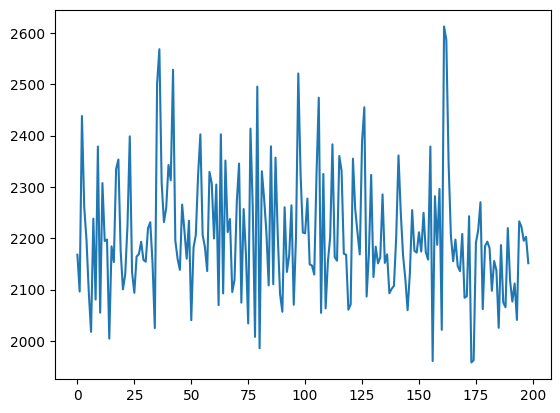

In [ ]:
o = algoGenetique(nb_gen = 200, nb_iter = 100, f_cout=calculate_cost, P_cross=1, P_mut=0.1)
#print(o[0])
#print(o[1])

980.4804594769053
[[63, 90], [], [15, 52, 87, 96, 29, 14, 95, 4, 53, 33, 107, 26, 34, 32, 75, 43, 30, 64, 74, 6, 47, 3, 88, 35, 106, 77, 23, 50, 59, 55, 81, 38, 40, 1, 19, 93, 101, 83, 16, 9, 48, 94, 25, 65, 46, 68, 10, 67, 60], [27, 7, 69, 45, 102], [104, 97, 79, 12, 91, 103, 36, 72, 17, 28, 44, 2, 99, 70, 42, 41, 5, 61, 82, 89, 54, 49, 57, 21, 62, 56, 80, 66, 84, 20, 73, 37, 58, 24, 98, 85, 18, 71], [], [86, 13, 100, 105, 31, 51, 11, 22, 76, 92, 8, 39, 78], []]


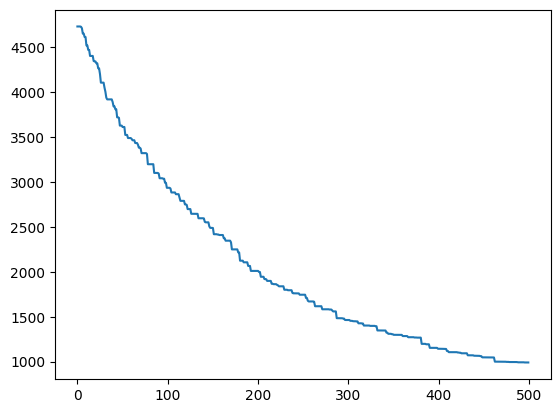

In [ ]:
o2 = ordo_gen_SMA(gen = gen_init(200), nb_iter = 500, f_cout=calculate_cost, P_cross=0, P_mut=0.1)
print(o2[0])
print(o2[1])

In [ ]:
is_schedule_valid([[], [], [79, 104, 25, 67, 60, 48, 69, 24, 98, 19, 93, 85, 94, 45, 101, 62, 84, 89, 42, 70, 99, 5, 41, 38, 49, 82, 44, 28, 91, 81, 2, 40, 21], [90, 63, 12, 17, 36, 72, 103, 55, 54, 59, 37, 61, 57, 58, 73, 20, 66, 80, 71, 16, 56, 18, 65, 7, 83, 9, 46, 10, 68, 1, 27, 86], [87, 3, 23, 96, 35, 78, 88, 15, 39, 14, 29, 33, 26, 75, 76, 105, 107, 11, 13, 22, 43, 92, 51, 34, 32, 30, 95, 31, 100, 4, 53, 64, 74, 8, 77, 6, 106, 50, 47, 52, 102, 97], [], [], []])

True

In [ ]:
def arcs_from_routes(routes):
    """Convert a list of routes into a set of arcs."""
    arcs = set()
    for route in routes:
        # Add arc from depot to first client, and from last client to depot
        if route:
            arcs.add((0, route[0]))
            arcs.add((route[-1], 0))

        # Add arcs between consecutive customers
        for i in range(len(route) - 1):
            arcs.add((route[i], route[i+1]))

    return arcs

def compare_schedules(schedule1, schedule2):
    """Compare two schedules and return the number of different arcs."""
    # Convert each schedule into a set of arcs
    arcs1 = arcs_from_routes(schedule1)
    arcs2 = arcs_from_routes(schedule2)

    # Calculate the symmetric difference between the two sets of arcs
    different_arcs = arcs1.symmetric_difference(arcs2)

    return len(different_arcs)

# Test function with two example schedules (for simplicity, using variations of the provided example)
schedule_a = [[86, 14, 78, 79], [46, 83, 45]]
schedule_b = [[86, 14, 79], [46, 83, 45, 69]]

compare_schedules(schedule_a, schedule_b)


6

In [ ]:
!pip install mesa


In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation

In [ ]:
class MyAgent(Agent):
    """ Un agent simple avec un identifiant unique et un état aléatoire. """
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = np.random.choice(["État 1", "État 2"])

    def step(self):

        pass

class MyModel(Model):
    """ Un modèle simple avec une activation aléatoire des agents. """
    def __init__(self, N):
        super().__init__()
        self.num_agents = N
        self.schedule = RandomActivation(self)


        for i in range(self.num_agents):
            agent = MyAgent(i, self)
            self.schedule.add(agent)

    def step(self):
        """ Exécute une étape de la simulation. """
        self.schedule.step()

In [ ]:

model = MyModel(10)


for i in range(5):
    model.step()


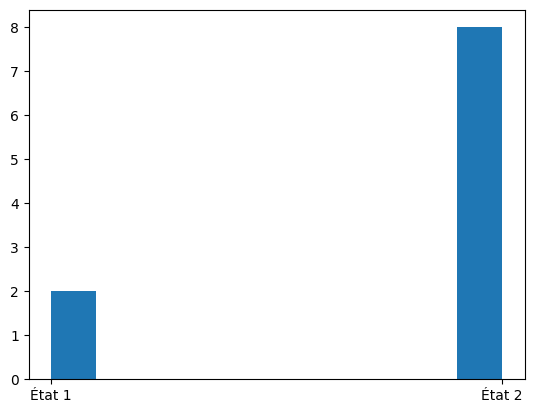

In [ ]:

data = [agent.state for agent in model.schedule.agents]
plt.hist(data)
plt.show()


In [ ]:
from mesa.time import StagedActivation

class RecuitAgent(Agent):
    def __init__(self, unique_id, model, temperature_initiale, iterations_par_cycle, facteur_refroidissement, etat_initial):
        super().__init__(unique_id, model)
        self.temperature_initiale = temperature_initiale
        self.iterations_par_cycle = iterations_par_cycle
        self.facteur_refroidissement = facteur_refroidissement
        self.etat_initial = etat_initial

    def step(self):
        self.res = self.model.ordo_recuit(self.temperature_initiale, self.iterations_par_cycle, self.facteur_refroidissement, self.etat_initial)
        self.model.results.append((self.res[0], self.res[1]))
        self.model.update_best_score(self.res[0], self.res[1])


        if self.model.best_score > self.res[0]:
            self.model.best_score = self.res[0]
            self.model.best_sol = self.res[1]

class TabouAgent(Agent):
    def __init__(self, unique_id, model, etat_initial, NbIterMax, Nbvoisins, Historique_scores):
        super().__init__(unique_id, model)
        self.etat_initial = etat_initial
        self.NbIterMax = NbIterMax
        self.Nbvoisins = Nbvoisins
        self.Historique_scores = Historique_scores

    def step(self):
        self.res = self.model.ordo_tabou(self.etat_initial, self.NbIterMax, self.Nbvoisins, self.Historique_scores)
        self.model.results.append((self.res[0], self.res[1]))
        self.model.update_best_score(self.res[0], self.res[1])

        if self.model.best_score > self.res[0]:
            self.model.best_score = self.res[0]
            self.model.best_sol = self.res[1]

class GenAgent(Agent):
    def __init__(self, unique_id, model, gen, nb_iter, P_cross, P_mut):
        super().__init__(unique_id, model)
        self.gen = gen
        self.nb_iter = nb_iter
        self.P_cross = P_cross
        self.P_mut = P_mut

    def step(self):
        self.res = self.model.ordo_gen(self.gen, self.nb_iter, self.P_cross, self.P_mut)
        self.model.results.append((self.res[0], self.res[1]))
        self.model.update_best_score(self.res[0], self.res[1])

        if self.model.best_score > self.res[0]:
            self.model.best_score = self.res[0]
            self.model.best_sol = self.res[1]

In [ ]:
import random

class OptimizationModel(Model):
    def __init__(self, nb_recuit, nb_tabou, nb_gen, calculate_cost):
        super().__init__()
        self.schedule = StagedActivation(self, stage_list=["step"])
        self.results = []
        self.best_score = float('inf')
        self.best_sol = None
        self.calculate_cost = calculate_cost
        self.EMP = []
        self.best_score_history = []


        for i in range(nb_recuit):
            temperature_initiale = 100
            iterations_par_cycle = 200
            facteur_refroidissement = 0.95
            etat_initial = None
            agent = RecuitAgent(i, self, temperature_initiale, iterations_par_cycle, facteur_refroidissement, etat_initial)
            self.schedule.add(agent)


        for i in range(nb_recuit, nb_recuit + nb_gen):
            gen = gen_init(100)
            nb_iter = 100
            P_cross = 0.7
            P_mut = 0.1
            agent = GenAgent(i, self, gen, nb_iter, P_cross, P_mut)
            self.schedule.add(agent)


        for i in range(nb_recuit + nb_gen, nb_recuit + nb_gen + nb_tabou):
            etat_initial = o[1]
            NbIterMax = 100
            Nbvoisins = 500
            Historique_scores = []
            agent = TabouAgent(i, self, etat_initial, NbIterMax, Nbvoisins, Historique_scores)
            self.schedule.add(agent)

    def ordo_recuit(self, temperature_initiale, iterations_par_cycle, facteur_refroidissement, etat_initial):
        meilleur_cout, meilleur_etat, _ = optimiser_ordonnancement_renforcement(
            temperature_initiale, iterations_par_cycle, facteur_refroidissement,
            self.calculate_cost, etat_initial)
        return meilleur_cout, meilleur_etat

    def ordo_gen(self, gen, nb_iter, P_cross, P_mut):
        score, solution = ordo_gen_SMA(gen, nb_iter, self.calculate_cost, P_cross, P_mut)
        return score, solution

    def ordo_tabou(self, etat_initial, NbIterMax, Nbvoisins, Historique_scores):
        s_star = algoTabou(etat_initial, NbIterMax, Nbvoisins, Historique_scores)
        score = self.calculate_cost(s_star)
        return score, s_star

    def former_EMP(self):


        meilleurs_scores = sorted(self.results, key=lambda x: x[0])[:len(self.results)//2]


        diversite_scores = []
        for i, (score1, sol1) in enumerate(meilleurs_scores):
            for score2, sol2 in meilleurs_scores[i+1:]:
                diversite = compare_schedules(sol1, sol2)
                diversite_scores.append((diversite, sol1, sol2))
        diversite_scores.sort(key=lambda x: x[0])


        for _, sol1, sol2 in diversite_scores[:len(diversite_scores)//2]:
            if sol1 not in self.EMP:
                self.EMP.append(sol1)
            if sol2 not in self.EMP and len(self.EMP) < len(meilleurs_scores) // 2:
                self.EMP.append(sol2)


    def update_best_score(self, new_score, solution):
        if new_score < self.best_score:
            self.best_score = new_score
            self.best_sol = solution
            self.best_score_history.append(self.best_score)
            print("Nouveau meilleur score:", self.best_score)


    def step(self):
        self.schedule.step()
        self.former_EMP()


        self.mettre_a_jour_solutions_des_agents()
        return self.best_score






    def mettre_a_jour_solutions_des_agents(self):
      for agent in self.schedule.agents:
        if isinstance(agent, (RecuitAgent, TabouAgent)):

            if self.EMP:
                agent.etat_initial = random.choice(self.EMP)
            else:
                agent.etat_initial = generate_valid_random_schedule(len(customers), len(vehicles))
        elif isinstance(agent, GenAgent):
            nouvelle_gen = []
            if self.EMP:
                nouvelle_gen.extend(self.EMP)
            while len(nouvelle_gen) < 50:
                nouvelle_gen.append(generate_valid_random_schedule(len(customers), len(vehicles)))
            agent.gen = nouvelle_gen

# Reinforcement

All functions above are described in the other sections of the report

## strategies for creating neighbors

*   Élément de liste
*   Élément de liste



In [ ]:


def IntraRouteSwap(ordo):

  # Check if the scheduling is not empty
    if len(ordo) == 0:
        return ordo

    # Select a truck at random
    r = random.randint(0, len(ordo) - 1)

    # Check if the selected truck has more than one item
    if len(ordo[r]) > 1:
        # Select two different indices in the truck
        a = random.randint(0, len(ordo[r]) - 1)
        b = random.randint(0, len(ordo[r]) - 1)
        while a == b:
            b = random.randint(0, len(ordo[r]) - 1)

        # Exchange elements at indices a and b
        ordo[r][a], ordo[r][b] = ordo[r][b], ordo[r][a]

    return ordo

def InterRouteSwap(ordo):

    if len(ordo) <= 1:
        return ordo


    # Select two different trucks at random
    r1 = random.randint(0, len(ordo) - 1)
    r2 = random.randint(0, len(ordo) - 1)

    # Make sure the trucks selected are different

    while r1 == r2:
        r2 = random.randint(0, len(ordo) - 1)

    if len(ordo[r1]) > 0 and len(ordo[r2]) > 0:
        # Select a random element from each non-empty list
        a = random.randint(0, len(ordo[r1]) - 1)
        b = random.randint(0, len(ordo[r2]) - 1)


        # Exchange items between the two lists
        ordo[r1][a], ordo[r2][b] = ordo[r2][b], ordo[r1][a]

    return ordo

def IntraRouteShift(ordo):
    if len(ordo) == 0:
        return ordo

    r = random.randint(0, len(ordo) - 1)

    if len(ordo[r]) > 1:
        # Select a random index in the truck
        a = random.randint(0, len(ordo[r]) - 1)

        # Generate a new position for the element
        newPos = random.randint(0, len(ordo[r]) - 1)
        while a == newPos:
            newPos = random.randint(0, len(ordo[r]) - 1)

        el_a = ordo[r].pop(a)
        ordo[r].insert(newPos, el_a)

    return ordo

def InterRouteShift(ordo):
    if len(ordo) <= 1:
        return ordo

    r1 = random.randint(0, len(ordo) - 1)
    r2 = random.randint(0, len(ordo) - 1)

    while r1 == r2:
        r2 = random.randint(0, len(ordo) - 1)

    if len(ordo[r1]) > 0 and len(ordo[r2]) > 0:

        # Select a random item from the first list

        a = random.randint(0, len(ordo[r1]) - 1)

        # Transfer element to second list
        el_a = ordo[r1].pop(a)
        ordo[r2].insert(0, el_a)

    return ordo

def TwoIntraRouteSwap(ordo):
    if len(ordo) == 1:
        return ordo

    r = random.randint(0, len(ordo) - 1)

    # Check if the selected truck has at least four items
    if len(ordo[r]) > 4:
        # Select two different random indices
        a_0 = random.randint(0, len(ordo[r]) - 2)
        a_1 = (a_0 + 1) % (len(ordo[r]) - 2)
        b_0 = random.randint(0, len(ordo[r]) - 2)
        b_1 = (b_0 + 1) % (len(ordo[r]) - 2)
        while b_0 in (a_0, a_1) or b_1 in (a_0, a_1):
            b_0 = random.randint(0, len(ordo[r]) - 1)
            b_1 = (b_0 + 1) % (len(ordo[r]) - 1)

        # Exchange elements between the two pairs of indices
        ordo[r][a_0], ordo[r][b_1] = ordo[r][b_1], ordo[r][a_0]
        ordo[r][a_1], ordo[r][b_0] = ordo[r][b_0], ordo[r][a_1]

    return ordo

def TwoIntraRouteShift(ordo):
    if len(ordo) == 0:
        return ordo

    r = random.randint(0, len(ordo) - 1)

    if len(ordo[r]) > 3:
        a_0 = random.randint(0, len(ordo[r]) - 2)
        a_1 = (a_0 + 1) % (len(ordo[r]) - 1)

        # Generate new positions for elements
        newPos_0 = random.randint(0, len(ordo[r]) - 2)
        while a_0 == newPos_0:
            newPos_0 = random.randint(0, len(ordo[r]) - 2)
        newPos_1 = (newPos_0 + 1) % (len(ordo[r]) - 1)

        el_a_0, el_a_1 = ordo[r].pop(a_0), ordo[r].pop(a_1)
        ordo[r].insert(newPos_0, el_a_0)
        ordo[r].insert(newPos_1, el_a_1)

    return ordo

def ElimineLaPlusPetiteRoute(ordo):
    if len(ordo) == 0:
        return ordo

    # Find the shortest non-empty list
    min_length = float('inf')
    min_index = -1
    for i, route in enumerate(ordo):
        if len(route) < min_length and len(route) > 0:
            min_length = len(route)
            min_index = i

    if min_index != -1:

        # Extract the shortest list and insert an empty list in its place
        shortest_route = ordo.pop(min_index)
        ordo.append([])

        # Insert the extracted list in a random position
        random_index = random.randint(0, len(ordo) - 1)
        ordo[random_index].extend(shortest_route)

    return ordo

def ElimineUneRouteAleatoire(ordo):
    if len(ordo) == 0:
        return ordo

    random_index = random.randint(0, len(ordo) - 1)
    removed_route = ordo.pop(random_index)


    # Insert an empty list in place of the deleted route
    ordo.append([])

    # Insert the deleted route in a random position
    random_index = random.randint(0, len(ordo) - 1)
    ordo[random_index].extend(removed_route)

    return ordo



## Usefull functions for the reinforcment

In [ ]:
def explore_voisin(ordo):    # returns a list of neighboring ordos
  L=[]
  L.append(IntraRouteSwap(ordo))
  L.append(InterRouteSwap(ordo))
  L.append(IntraRouteShift(ordo))
  L.append(InterRouteShift(ordo))
  L.append(TwoIntraRouteSwap(ordo))
  L.append(TwoIntraRouteShift(ordo))
  L.append(ElimineLaPlusPetiteRoute(ordo))
  L.append(ElimineUneRouteAleatoire(ordo))
  Lv=[]
  for i in range(8):
    Lv.append(calculate_cost(L[i]))      #lis of cost for each neighbors
  return [L,Lv]

def action_aleatoire(i,ordo):         #functions to retrieve the selected neighbor with e-greedy
  if i==0:
    return (IntraRouteSwap(ordo))
  if i==1:
    return(InterRouteSwap(ordo))
  if i==2:
    return(IntraRouteShift(ordo))
  if i==3:
    return(InterRouteShift(ordo))
  if i==4:
    return(TwoIntraRouteSwap(ordo))
  if i==5:
    return(TwoIntraRouteShift(ordo))
  if i==6:
    return(ElimineLaPlusPetiteRoute(ordo))
  if i==7:
    return(ElimineUneRouteAleatoire(ordo))

# Algorithm E-greedy
def e_greedy(epsilon):
  p=random.random()
  if p<=epsilon:
    return random.randint(0,7)
  else:
    return -1


def apprentissage_voisin(ordo):        # function that selects the neighbor with the E-greedy criterion
  ordotemp=ordo
  i=e_greedy(epsilon)
  if i<0:
    L=explore_voisin(ordo)
    j=L[1].index(max(L[1]))   #we find the best neighbors
    ordotemp=L[0][j]
    cout=L[1][j]
  else:
    ordotemp=action_aleatoire(i,ordo)
    cout=calculate_cost(ordotemp)
  global Qlearning                           # update the Qlearning for all fuctions
  Qlearning=Qlearning*(1-Lrate) + Lrate*(pena + Drate*cout)

  return(ordotemp)


## SR with reinforcment

In [ ]:
def optimiser_ordonnancement_renforcement(temperature_initiale, iterations_par_cycle, facteur_refroidissement, calculer_cout, etat_initial):
    """
    Optimizes scheduling using simulated annealing with a specific neighbor strategy.
    Returns the evolution of the best cost in addition to the best cost and the best state.
    """
    # Generate random scheduling if no initial state is provided

    if etat_initial is None:
        etat_courant = generate_random_schedule(len(customers), len(vehicles))
    else:
        etat_courant = etat_initial

    meilleur_etat = deepcopy(etat_courant)
    cout_courant = calculer_cout(etat_courant)
    meilleur_cout = cout_courant
    couts_evolution = [meilleur_cout]      # Stores the best initial cost
    temperature = temperature_initiale

    while temperature > 1:
        for _ in range(iterations_par_cycle):
            voisin = apprentissage_voisin(etat_courant)         # here we add the reinforcment method for choosing the neigbors
            cout_voisin = calculer_cout(voisin)
            delta_cout = cout_voisin - cout_courant

            if delta_cout < 0 or random.random() < math.exp(-delta_cout / temperature):
                etat_courant = voisin
                cout_courant = cout_voisin

                if cout_voisin < meilleur_cout:
                    meilleur_etat = deepcopy(voisin)
                    meilleur_cout = cout_voisin

        couts_evolution.append(meilleur_cout)  # Records the best cost of this cycle
        temperature *= facteur_refroidissement

    return meilleur_cout, meilleur_etat, couts_evolution

## Tabou with reinforcment

In [ ]:
def algoTabouAvecDL(s_depart, NbIterMax, Nbvoisins, Historique_scores):
    s_avec_0 = ordo_to_tab_list(s_depart)
    s = [x for x in s_avec_0 if x != 0]
    s_star = s
    nb_iter = 0
    T = []
    meil_score = calculate_cost(tab_list_to_ordo(s_star))

    while (nb_iter < NbIterMax):
        nb_iter += 1
        print("Step " + str(nb_iter))
        V = voisins(s, Nbvoisins)
        v, M = choixVoisin(V, T)

        if v is None and M is None:
            v, M = v, calculate_cost(tab_list_to_ordo(v))

        if (M < meil_score):
          s=v
          s_star = s
          meil_score = M
          print("Amélioration :", meil_score)
        else:
          s=v
          T.append(v)

        Historique_scores.append(meil_score)

    return tab_list_to_ordo(s_star)


def voisins(sol, NbVoisins):

  # Recover neighbors with deep learning algo
  V=[]
  for i in range(NbVoisins):

    solBonFormat=tab_list_to_ordo(sol)
    v=apprentissage_voisin(solBonFormat)           # we add the reinforcment method here
    V.append(ordo_to_tab_list(v))

  if(len(V)==0):
    print("Pas de solutions voisines possibles")
  return V


def choixVoisin(V, T):
    if not V:
        print("Pas de solutions voisines possibles")
        return None, None  # Or another suitable value to indicate the absence of a solution

    # Checks if all elements of V are already in T
    if all(v in T for v in V):
        print("Tous les voisins sont déjà dans T")
        return None, None

    # Initialisation
    MeilleurVoisin = None
    MeilleurScore = float('inf')   # Initializes with a very high value

    # We iterate on all the neighbors to find the best one
    for k in range(len(V)):
        if V[k] not in T:
            Score = calculate_cost(tab_list_to_ordo(V[k]))
            if Score < MeilleurScore:
                MeilleurVoisin = k
                MeilleurScore = Score

    # Checks if a neighbor has been found
    if MeilleurVoisin is not None:
        return V[MeilleurVoisin], MeilleurScore
    else:
        # Handles the case where no valid neighbor is found
        print("Aucun voisin valide trouvé")
        return None, None

Test without reinforcment

Step 0
Amélioration : 4237.502518508003
Step 1
Amélioration : 3666.0013443745434
Step 2
Amélioration : 3169.219248695912
Step 3
Amélioration : 2957.678809128028
Step 4
Amélioration : 2784.7356536005555
Step 5
Amélioration : 2679.2899754628
Step 6
Amélioration : 2566.4581148161606
Step 7
Amélioration : 2471.279989952208
Step 8
Amélioration : 2322.846974756232
Step 9
Amélioration : 2219.7688996147413
Step 10
Amélioration : 2109.326571073754
Step 11
Amélioration : 2053.0184993129105
Step 12
Amélioration : 2001.077727415381
Step 13
Amélioration : 1918.6553488766822
Step 14
Amélioration : 1794.0648855022812
Step 15
Amélioration : 1774.7510480001981
Step 16
Amélioration : 1699.3985893034217
Step 17
Amélioration : 1647.0514989422738
Step 18
Amélioration : 1590.3405280496017
Step 19
Amélioration : 1577.044076997339
Step 20
Amélioration : 1526.0035701579043
Step 21
Amélioration : 1470.3322689354472
Step 22
Amélioration : 1442.0668431300307
Step 23
Amélioration : 1416.4256131060786
Step 24
Améli

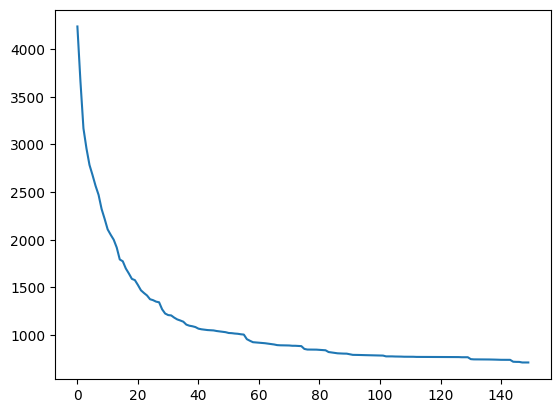

In [ ]:

Qlearning = 10
epsilon = 0.05
Lrate = 0.5
Drate = 0.2
pena = 1

Historique_scores=[]
s_depart = generate_random_schedule(100,8)
ordo_tabou_avec=algoTabou(s_depart, 150, 500, Historique_scores)
plt.plot(Historique_scores)

## Test with reinforcment

In [ ]:


Qlearning = 10
epsilon = 0.3
Lrate = 0.8
Drate = 0.1
pena=1
Historique_scores=[]
s_depart = generate_random_schedule(100,8)
ordo_tabou_avec=algoTabouAvecDL(s_depart, 500, 100, Historique_scores)
plt.plot(Historique_scores)

Step 1
Amélioration : 4543.5881822232905
Step 2
Amélioration : 4062.5653737397033
Step 3
Amélioration : 3557.8714364067096
Step 4
Amélioration : 3182.530771164171
Step 5
Amélioration : 3067.9732838134523
Step 6
Amélioration : 2976.3113967516088
Step 7
Amélioration : 2943.449709138215
Step 8


KeyboardInterrupt: 

## SMA with reinforcment

Étape 1
Nouveau meilleur score: 2195.4395481199317
Nouveau meilleur score: 2001.9927573695131
Step 0
Amélioration : 1665.7576408372574
Step 1
Amélioration : 1511.2753805747261
Step 2
Amélioration : 1488.5638562856018
Step 3
Amélioration : 1456.3065273904972
Step 4
Amélioration : 1434.7648536763295
Step 5
Amélioration : 1402.1816679406315
Step 6
Amélioration : 1381.4060749596674
Step 7
Amélioration : 1357.6406362354983
Step 8
Amélioration : 1334.354257935932
Step 9
Amélioration : 1304.0381479697382
Step 10
Amélioration : 1271.3821308013764
Step 11
Amélioration : 1238.2909257953115
Step 12
Amélioration : 1209.2750972398696
Step 13
Amélioration : 1201.60074662544
Step 14
Amélioration : 1185.4638044886021
Step 15
Amélioration : 1127.9809294162937
Step 16
Amélioration : 1113.2875506241767
Step 17
Amélioration : 1100.3138490354136
Step 18
Amélioration : 1060.1474098037443
Step 19
Amélioration : 1028.1699849096876
Step 20
Amélioration : 1016.4459495881802
Step 21
Amélioration : 997.5894449644

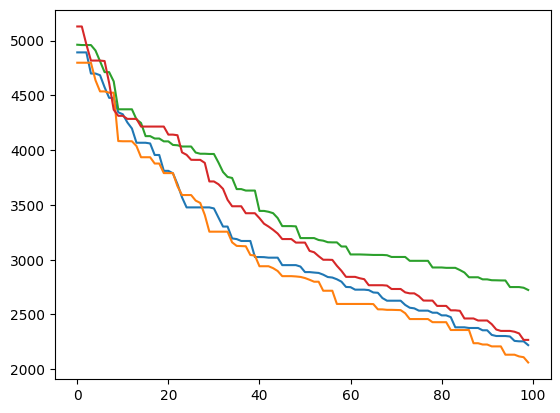

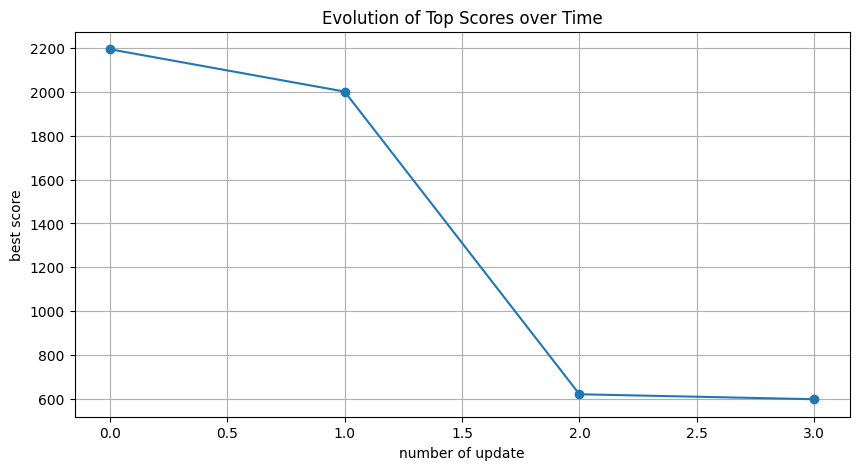

In [ ]:
Qlearning = 10
epsilon = 0.05
Lrate = 0.9
Drate = 0.2
pena=1

model = OptimizationModel(nb_recuit=0, nb_tabou=2, nb_gen=2, calcul_cout=calcul_cout)


for i in range(2):
    print(f"Étape {i+1}")
    model.step()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(model.best_score_history, marker='o', linestyle='-')
plt.title('Evolution of Top Scores over Time')
plt.xlabel('number of update')
plt.ylabel('best score')
plt.grid(True)
plt.show()